In [12]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import DataLoader, TensorDataset


In [13]:
# Config & Setup Details
cfg_batch_size  = 50
cfg_max_epochs  = 10
cfg_num_workers = 2

# Learning Config
cfg_split   = 0.8
cfg_seq_len = 180

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "transformer"


In [14]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [23]:
# Load Data - Parse the Date Column
df_raw = pd.read_csv(cfg_data_url_train, parse_dates=["date"])

print(f"Raw Shape: {df_raw.shape}")
print(df_raw.head())
print("\n********\n")

# Format Date Column to DateTime
df_raw['date'] = pd.to_datetime(df_raw['date'], format=cfg_data_date_fmt)

# Get Sales (Sum across all Stores) Grouped by Date
df_grouped_date = df_raw.groupby(['date'])['sales'].sum().reset_index()
print(f"Grouped by Date Shape: {df_grouped_date.shape}")
print(df_grouped_date)
print("\n********\n")

# Resetting the index
df_sales = df_grouped_date.reset_index()

# Show the New Table
print(f"DF Sales Shape: {df_sales.shape}")
print(df_sales)
print(f"Training Cols: {df_sales.columns}")
print("\n********\n")

df_sales_avg = df_sales
df_sales_avg['sales'] = df_sales_avg['sales'].rolling(window=7, min_periods=1).mean()



sales_data = df_sales['sales'].values.reshape(-1, 1)
scaled_sales_data = scaler.fit_transform(sales_data)

sales_data_avg = df_sales_avg['sales'].values.reshape(-1, 1)
scaled_sales_data_avg = scaler.fit_transform(sales_data_avg)


Raw Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

********

Grouped by Date Shape: (1826, 2)
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]

********

DF Sales Shape: (1826, 3)
      index       date  sales
0         0 2013-01-01  13696
1         1 2013-01-02  13678
2         2 2013-01-03  14488
3         3 2013-01-04  15677
4         4 2013-01-05  16237
...     ...        ...    ...
1821   1821 2017-12-27  20378
1822   1822 2017-12-28  21885
1823   1823 2017-12-29  23535
1824   1824 2017-12-30  24988
1825   1825 2017-12-31  26420

[1826 rows x 3 columns]
Training Col

In [63]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Preprocess the historical data
seq_length = 180
x, y = create_sequences(scaled_sales_data_avg, seq_length)

# Split the data into training and testing sets
train_size = int(len(y) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()


x_train.shape


torch.Size([1316, 180, 1])

In [64]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the LSTM model
input_size = 1
hidden_size = 100
num_layers = 1
output_size = 1
model = LSTM(input_size, hidden_size, num_layers, output_size)

In [65]:
# Set training parameters
learning_rate = 0.005
num_epochs = 100

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    # Reshape or squeeze x_train to match the expected input shape
    x_train_adjusted = x_train
    outputs = model(x_train_adjusted).squeeze()
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/100], Loss: 0.0506
Epoch [20/100], Loss: 0.0433


KeyboardInterrupt: 

In [58]:
with torch.no_grad():
    test_outputs = model(x_test).squeeze()  # Add .squeeze() here
    test_loss = criterion(test_outputs, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0702


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([347, 1])) that is different to the input size (torch.Size([347])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



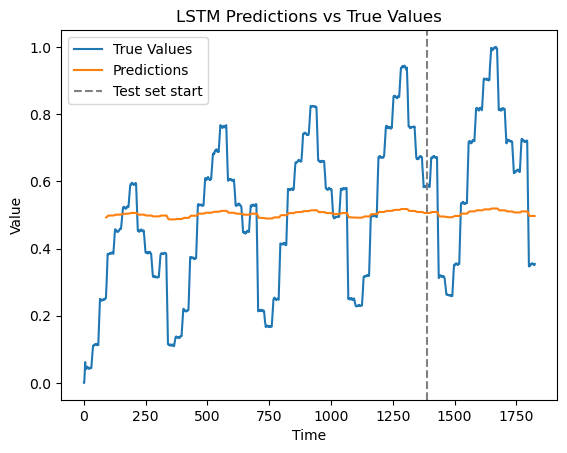

In [62]:
import matplotlib.pyplot as plt

# Concatenate the training and test predictions
with torch.no_grad():
    train_outputs = model(x_train).squeeze().numpy()
    test_outputs = model(x_test).squeeze().numpy()
all_outputs = np.concatenate((train_outputs, test_outputs))

# Calculate the index where the test set starts
test_start_index = len(scaled_sales_data_avg) - len(y_test) - seq_length

# Plot the true values and the predictions
plt.plot(scaled_sales_data_avg, label="True Values")
plt.plot(range(seq_length, seq_length + len(all_outputs)), all_outputs, label="Predictions")
plt.axvline(x=test_start_index, color='gray', linestyle='--', label="Test set start")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()